(real-time-simple-update)=

# Real time simple update (SU)

In [1]:
%config InlineBackend.figure_formats = ['svg']
import autoray as ar
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm  # for progress bar

import quimb as qu
import quimb.tensor as qtn

mpl.style.use(qu.NEUTRAL_STYLE)

In [2]:
Lx = 11
Ly = 11

edges = qtn.edges_2d_square(Lx, Ly, cyclic=False)
sites = sorted({s for e in edges for s in e})

# heisenberg interaction
h2 = -qu.pauli("X") & qu.pauli("X")
# quenched random onsite z-fields
h1 = -3.04438 * qu.pauli("Z")

In [3]:
# all zero-state
psi = qtn.TN_from_sites_product_state(
    site_map={site: [1.0, 0.0] for site in sites}
)

# make size 1 lattice bonds
for cooa, coob in edges:
    psi[cooa].new_bond(psi[coob])

psi

TensorNetworkGenVector(tensors=121, indices=341)

In [4]:
# create simple update gauges
gauges = {}
psi.gauge_all_simple_(gauges=gauges)

TensorNetworkGenVector(tensors=121, indices=341)

In [5]:
results = {}

# truncation options
max_bond = 16
cutoff = 1e-6

t = 0.0
dt = 0.04

U2 = ar.do("linalg.expm", -1j * dt * h2)
U1 = ar.do("linalg.expm", -1j * dt * h1)

In [6]:
mag_terms = {(site,): qu.pauli("Z") for site in [(Lx // 2, Ly // 2)]}

cluster_sets = {c: tuple(psi.gen_gloops_sites(c)) for c in [0, 4, 6]}

In [7]:
[len(cs) for cs in cluster_sets.values()]

[0, 100, 280]

In [8]:
def measure():
    if "times" in results and results["times"][-1] == t:
        # already measured this time
        return

    results.setdefault("times", []).append(t)

    for c, gloops in cluster_sets.items():
        results.setdefault(("norm", c), []).append(
            psi.norm_gloop_expand(
                gauges=gauges,
                gloops=gloops,
                optimize="random-greedy",
                autocomplete=True,
                autoreduce=True,
            ).real
        )

    # store some intermediate state for efficiency
    info = {}
    for c, gloops in cluster_sets.items():
        results.setdefault(("mag", c), []).append(
            psi.compute_local_expectation_gloop_expand(
                mag_terms,
                gauges=gauges,
                normalized="prod",
                gloops=gloops,
                optimize="random-greedy",
                autocomplete=True,
                info=info,
            ).real
            / len(mag_terms)
        )

In [12]:
for i in tqdm.trange(10):
    measure()

    for edge in qtn.tnag.tebd.edge_coloring(
        edges,
        "random_sequential",
        group=False,
    ):
        psi.gate_simple_(
            U2,
            where=edge,
            gauges=gauges,
            max_bond=max_bond,
            cutoff=cutoff,
            renorm=False,
        )

    for site in sites:
        psi.gate_simple_(U1, (site,), gauges=gauges)

    # ensure gauge is equilibrated
    psi.gauge_all_simple_(
        max_iterations=1000,
        tol=1e-6,
        gauges=gauges,
        progbar=False,
    )

    t += dt

measure()

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [11:32<00:00, 69.24s/it]


In [13]:
psi

TensorNetworkGenVector(tensors=121, indices=341)

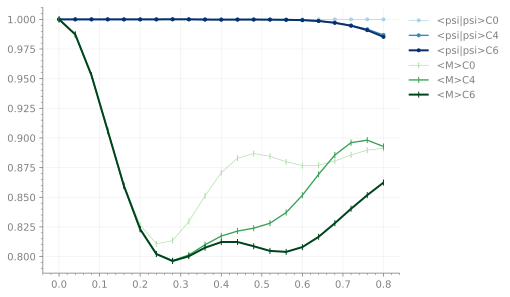

In [14]:
for i, c in enumerate(cluster_sets):
    plt.plot(
        results["times"],
        results["norm", c],
        ".-",
        label=f"<psi|psi>C{c}",
        color=mpl.cm.Blues((i + 1) / len(cluster_sets)),
        linewidth=2 * (i + 1) / len(cluster_sets),
    )

for i, c in enumerate(cluster_sets):
    plt.plot(
        results["times"],
        results["mag", c],
        "|-",
        label=f"<M>C{c}",
        color=mpl.cm.Greens((i + 1) / len(cluster_sets)),
        linewidth=2 * (i + 1) / len(cluster_sets),
    )

plt.legend(bbox_to_anchor=(1, 1))
plt.show()
plt.close()